## EDA 과제 - Book Popularity

- 과제 목표: TIOBE index 상위 9개 언어와 R에 대해 한국에서 출판된 도서 정보를 기준으로 프로그래밍 언어의 인기도 분석 

#### 주의 사항 
- TIOBE INDEX 20위까지 확장해서 검색한 후 데이터 수집 
- 책 가격과 페이지 수 함께 수집 
- 검색어 'C'는 검색 결과가 2000건 이상이기 때문에 추가 작업 필요 


In [303]:
import os
import sys
import urllib.request
import json 
import datetime 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [4]:
client_id = "eXEW1zGdvBb9iT4yudBS"
client_secret = "jpdR0qWR7m"

#### 문제 1 

> 과제 설명 첫 두 페이지에 제시한 TIOBE INDEX의 상위 9개 언어에 R(14위)까지 포함해서 총 10개 언어에 대해 출판 책 정보를 수집하세요

##### 데이터 크롤링

In [ ]:
# 검색할 프로그래밍 언어 리스트에 저장 

list_language = ['python', '파이썬', 'C', 'C언어', 'Java', '자바', 'C++', 'C#', 'Visual Basic', '비쥬얼 베이직', 'JavaScript', '자바스크립트', 'SQL', '에스큐엘', 'PHP', 'R']

In [329]:
# 검색 url 생성 함수

def gen_search_url(api_node, search_text, start_num, disp_num):
    base = "https://openapi.naver.com/v1/search"
    node = "/" + api_node + "_adv.json"
    param_start = "?start=" + str(start_num)
    param_disp = "&display=" + str(disp_num)
    d_titl = "&d_titl=" + urllib.parse.quote(search_text)
    
    return base + node + param_start + param_disp + d_titl + '&d_catg=280'

In [330]:
# 검색 결과 가져오는 함수

def get_result_onpage(url):
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    response = urllib.request.urlopen(request)
    print("[%s] Url Request Success" % datetime.datetime.now())
    return json.loads(response.read().decode("utf-8"))

In [333]:
# 검색 결과 데이터 프레임화 함수

def get_fields(json_data):

    title = [each["title"] for each in json_data["items"]]
    author = [each["author"] for each in json_data["items"]]
    price = [each["price"] for each in json_data["items"]]
    publisher = [each["publisher"] for each in json_data["items"]]
    pubdate = [each["pubdate"] for each in json_data["items"]]
    isbn = [each["isbn"] for each in json_data["items"]]
    link = [each["link"] for each in json_data["items"]]

    result_pd = pd.DataFrame({
        "title": title, 
        "author": author, 
        "price": price, 
        "publisher": publisher,  
        "pubdate": pubdate,
        "isbn": isbn,
        "link": link
    }, columns=["title", "author", "price", "publisher", "pubdate", "isbn", "link"]) 
    return result_pd

In [334]:
# url = gen_search_url("book", '파이썬', 1, 5)
# one_result = get_result_onpage(url)
# result = get_fields(one_result)
# one_result


[2022-04-26 22:26:18.929378] Url Request Success


{'lastBuildDate': 'Tue, 26 Apr 2022 22:25:46 +0900',
 'total': 766,
 'start': 1,
 'display': 5,
 'items': [{'title': '만들면서 배우는 <b>파이썬</b>과 40개의 작품들 (자동화, 크롤링, 이미지처리, 데이터분석, 웹페이지, GUI 프로그램, 게임)',
   'link': 'http://book.naver.com/bookdb/book_detail.php?bid=21982844',
   'image': 'https://bookthumb-phinf.pstatic.net/cover/219/828/21982844.jpg?type=m1&udate=20220221',
   'author': '장문철',
   'price': '18800',
   'discount': '16920',
   'publisher': '앤써북',
   'pubdate': '20220228',
   'isbn': '1185553932 9791185553931',
   'description': '이 책은 내 업무와 생활에 바로 적용할 수 있는 40개의 프로그램을 직접 코딩해서 만들어보고, 동시에 <b>파이썬</b>을 자연스럽게 이해할 수 있게 구성하였다!<b>파이썬</b> 기초 문법 떼고 자동화, 크롤링, 이미지처리, 데이터분석, 웹페이지, GUI 프로그램, 게임, 인공지능 관련 40개 프로그램 직접 <b>파이썬</b> 코딩하며 만들어... '},
  {'title': '이것이 취업을 위한 코딩 테스트다 with <b>파이썬</b> (취업과 이직을 결정하는 알고리즘 인터뷰 완벽 가이드)',
   'link': 'http://book.naver.com/bookdb/book_detail.php?bid=16439154',
   'image': 'https://bookthumb-phinf.pstatic.net/cover/164/391/16439154.jpg?type=m1&udate=20200928',
   'a

In [335]:
# 네이버 API 검색 결과 수집 및 데이터 프레임 생성 

list_language = ['python', '파이썬', 'C', 'Java', '자바', 'C++', 'C#', 'VisualBasic', '비쥬얼베이직', 'JavaScript', '자바스크립트', 'SQL', '에스큐엘', 'PHP', 'R']
df_book = pd.DataFrame(columns=['title', 'author', 'price', 'publisher', 'pubdate', 'isbn', 'link', 'language'])

for language in list_language:
    for i in range(1, 1000, 100):
        url = gen_search_url("book", language, i, 100)
        one_result = get_result_onpage(url)
        result = get_fields(one_result)
        result['language'] = language
        df_book = pd.concat([df_book, result], axis=0, ignore_index=True)

[2022-04-26 22:26:29.865311] Url Request Success
[2022-04-26 22:26:30.308180] Url Request Success
[2022-04-26 22:26:30.498771] Url Request Success
[2022-04-26 22:26:30.674979] Url Request Success
[2022-04-26 22:26:30.861993] Url Request Success
[2022-04-26 22:26:31.084980] Url Request Success
[2022-04-26 22:26:31.262992] Url Request Success
[2022-04-26 22:26:31.500257] Url Request Success
[2022-04-26 22:26:31.712242] Url Request Success
[2022-04-26 22:26:31.905241] Url Request Success
[2022-04-26 22:26:32.361247] Url Request Success
[2022-04-26 22:26:32.817240] Url Request Success
[2022-04-26 22:26:33.238245] Url Request Success
[2022-04-26 22:26:33.691518] Url Request Success
[2022-04-26 22:26:34.103492] Url Request Success
[2022-04-26 22:26:34.523471] Url Request Success
[2022-04-26 22:26:34.941426] Url Request Success
[2022-04-26 22:26:35.298783] Url Request Success
[2022-04-26 22:26:35.462648] Url Request Success
[2022-04-26 22:26:35.641638] Url Request Success
[2022-04-26 22:26:36

In [336]:
# 여유가 된다면 title의 태그를 제거해보자. 
df_book.head()

,title,author,price,publisher,pubdate,isbn,link,language
0,"파이썬 코딩의 기술 (Effective <b>Python</b> 2nd,똑똑하게 코...",브렛 슬라킨,32000,길벗,20201030,1165213192 9791165213190,http://book.naver.com/bookdb/book_detail.php?b...,python
1,"SPSS, R, <b>Python</b>을 활용한 Kaggle 데이터 전략 실무 연...",김광용|정성원|이성택|이재모|임은택,28000,청람,20220415,8959728756 9788959728756,http://book.naver.com/bookdb/book_detail.php?b...,python
2,파이썬 딥러닝 파이토치 (<b>Python</b> Deep Learning PyTo...,이경택|방성수|안상준,25000,정보문화사,20201008,8956748578 9788956748573,http://book.naver.com/bookdb/book_detail.php?b...,python
3,OpenCV.<b>Python</b> 머신러닝 딥러닝 프로그래밍,김동근,26000,가메,20220331,8980783116 9788980783113,http://book.naver.com/bookdb/book_detail.php?b...,python
4,영상 처리 및 응용 (OpenCV-<b>Python</b>으로 배우는),정성환,35000,생능출판,20201124,8970504419 9788970504414,http://book.naver.com/bookdb/book_detail.php?b...,python


##### 한글, 영어로 표기가 다른 언어 통일해주기 

In [337]:
df_book['language'] =  df_book['language'].str.replace('파이썬', 'python')
df_book['language'] =  df_book['language'].str.replace('자바스크립트', 'JavaScript')
df_book['language'] =  df_book['language'].str.replace('자바', 'Java')
df_book['language'] =  df_book['language'].str.replace('비쥬얼베이직', 'VisualBasic')

In [338]:
df_book.groupby(['language']).count()

,title,author,price,publisher,pubdate,isbn,link
language,,,,,,,
C,1000,1000,1000,1000,1000,1000,1000
C#,308,308,308,308,308,308,308
C++,1000,1000,1000,1000,1000,1000,1000
Java,1654,1654,1654,1654,1654,1654,1654
JavaScript,510,510,510,510,510,510,510
PHP,205,205,205,205,205,205,205
R,406,406,406,406,406,406,406
SQL,471,471,471,471,471,471,471
VisualBasic,363,363,363,363,363,363,363


#### 문제 2

> 문제 1에서 수집한 데이터를 ISBN 정보로 unique 검사 후 중복 데이터를 정리 하세요

In [218]:
len(df_book['isbn'].unique())

5681

In [219]:
# 중복 제거 전 
len(df_book)

6890

In [220]:
# Java 검색 결과에 Javascript 검색결과가 포함되기 때문에 둘 사이의 중복을 제거하면서 Javascript 검색 결과를 유지하기 위해 keep='last' 지정 

df_book2 = df_book.drop_duplicates(['isbn'], keep='last', inplace=True, ignore_index=True)

In [221]:
# 중복 제거 후 
len(df_book)

5681

In [222]:
df_book.groupby(['language']).count()

,title,author,price,publisher,pubdate,isbn
language,,,,,,
C,615,615,615,615,615,615
C#,301,301,301,301,301,301
C++,978,978,978,978,978,978
Java,1043,1043,1043,1043,1043,1043
JavaScript,462,462,462,462,462,462
PHP,199,199,199,199,199,199
R,405,405,405,405,405,405
SQL,421,421,421,421,421,421
VisualBasic,351,351,351,351,351,351


#### 문제 3 

> 문제 2의 결과에서 각 언어별 출판물의 양으로 순위를 매겨주세요. 적절히 시각화하여 그 양도 확인해주세요.

##### 순위 매기기

In [223]:
df_book['language'].unique()

array(['python', 'C', 'Java', 'C++', 'C#', 'VisualBasic', 'JavaScript',
       'SQL', 'PHP', 'R'], dtype=object)

In [224]:
# 각 프로그래밍 언어별 출판물의 양 집계

df_book_count = df_book['language'].value_counts().to_frame()
df_book_count

,language
Java,1043
C++,978
python,906
C,615
JavaScript,462
SQL,421
R,405
VisualBasic,351
C#,301
PHP,199


In [225]:
# 언어별 출판물 순위 표기 

df_book_count['rank'] = df_book_count['language'].rank(ascending=False)
df_book_count

,language,rank
Java,1043,1.0
C++,978,2.0
python,906,3.0
C,615,4.0
JavaScript,462,5.0
SQL,421,6.0
R,405,7.0
VisualBasic,351,8.0
C#,301,9.0
PHP,199,10.0


##### 순위 시각화

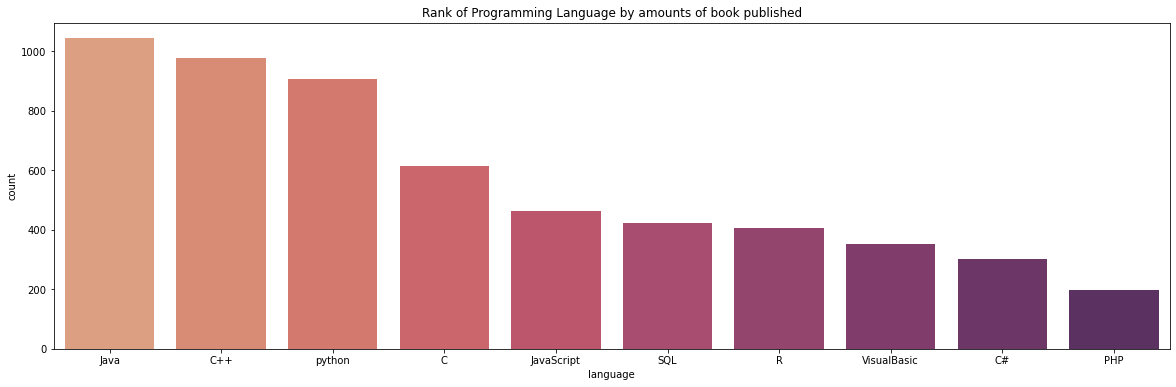

In [229]:
# 막대바 위에 수치를 나타내려면?

sns.countplot('language', data=df_book, order=df_book['language'].value_counts(ascending=False).index, palette='flare')
sns.color_palette('Set3', 10)
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.xticks(rotation=0)
 
plt.title('Rank of Programming Language by amounts of book published')
plt.show();

#### 문제 4

> 수집된 정보를 기반으로 우리나라의 컴퓨터 언어 관련 출판사 순위를 확인하세요,

In [234]:
# 출판사의 개수가 554개이므로 상위 10개 출판사만 확인 
len(df_book['publisher'].unique())

554

In [236]:
df_book.columns

Index(['title', 'author', 'price', 'publisher', 'pubdate', 'isbn', 'language'], dtype='object')

In [239]:
df_book.head()

,title,author,price,publisher,pubdate,isbn,language
0,OpenCV.<b>Python</b> 머신러닝 딥러닝 프로그래밍,김동근,26000,가메,20220331,8980783116 9788980783113,python
1,영상 처리 및 응용 (OpenCV-<b>Python</b>으로 배우는),정성환,35000,생능출판,20201124,8970504419 9788970504414,python
2,처음 만나는 AI 수학 with <b>Python</b> (한 권으로 배우는 인공지...,아즈마 유키나가,23000,영진닷컴,20210115,8931463375 9788931463378,python
3,빅데이터분석 및 인공지능 (쉽고 간단한 예제를 이용한 빅데이터분석 및 인공지능 실습...,조준모,26000,인피니티북스,20210225,118557879X 9791185578798,python
4,<b>Python</b>으로 배우는 문제해결과 인공지능,김현정|오경선,23000,인피니티북스,20210225,1185578811 9791185578811,python


In [260]:
# 상위 10개 출판사 순위 표기 
df_book_publisher = df_book['publisher'].value_counts()[:10].to_frame()
df_book_publisher['rank'] = df_book_publisher['publisher'].rank(ascending=False)
df_book_publisher

,publisher,rank
한빛미디어,370,1.0
에이콘출판,305,2.0
정보문화사,253,3.0
영진닷컴,217,4.0
Packt(GCOScience),169,5.0
성안당,125,6.0
위키북스,119,7.0
길벗,114,8.0
인포북,111,9.0
삼각형,106,10.0


##### 출판사 순위 시각화

In [249]:
# 한글대응

import matplotlib.pyplot as plt
import platform

path = "c:/Windows/Fonts/malgun.ttf"
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    rc("font", family="AppleGothic")
elif platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc("font", family=font_name)
else:
    print("Unknown system...sorry~~~")

get_ipython().run_line_magic("matplotlib", "inline")

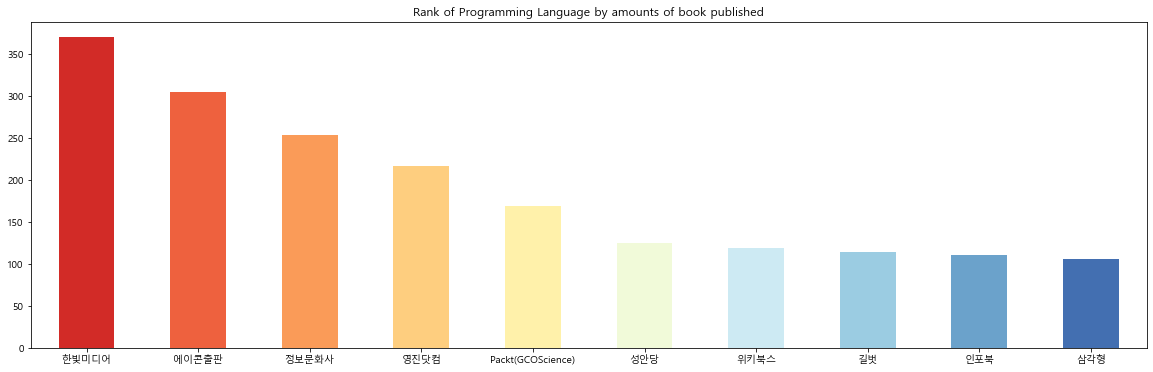

In [261]:
df_book_publisher['publisher'].plot.bar(color=sns.color_palette('RdYlBu', 10))
sns.color_palette('Set3', 10)
fig=plt.gcf()
fig.set_size_inches(20,6)
plt.xticks(rotation=0)
plt.title('Rank of Programming Language by amounts of book published')
plt.show();

#### 문제 5

> 출판일 기준, 최근 2년간(20년, 21년) 데이터와 그 전 3년(17년, 18년, 19년) 데이터를 비교해주세요. 

In [295]:
# 최근 2년간 데이터와 그 전 3년 데이터로 이분할 

df_book_date1 = df_book [df_book['pubdate'].between('2017-01-01', '2019-12-31')]
df_book_date2 = df_book [df_book['pubdate'].between('2020-01-01', '2021-12-31')]

In [273]:
# 파이차트를 그리기 위해 데이터 준비 

df_book_group1 = df_book_date1['language'].value_counts().to_frame()
df_book_group1

,language
python,214
R,106
Java,92
C,56
JavaScript,51
C++,44
SQL,28
C#,26
PHP,14
VisualBasic,5


In [272]:
df_book_group2 = df_book_date2['language'].value_counts().to_frame()
df_book_group2

,language
python,164
R,49
C++,26
Java,23
C,21
SQL,19
JavaScript,17
C#,11
PHP,5
VisualBasic,1


In [298]:
# 인덱스 열 이름 지정 
df_book_group1.index.name="planguage"
df_book_group2.index.name="planguage"

In [289]:
df_book_group1['language']

planguage
python         214
R              106
Java            92
C               56
JavaScript      51
C++             44
SQL             28
C#              26
PHP             14
VisualBasic      5
Name: language, dtype: int64

In [320]:
# 각 데이터 시각화 및 비교분석

fig = make_subplots(rows=1, cols=2, shared_xaxes=False,
                    specs = [[{"type": "pie"}, {"type": "pie"}]]
                    )

fig.add_trace(go.Pie(labels=df_book_group1.index, 
                    values=df_book_group1['language'], 
                    title='Popularity of Programming Language in 2017~2019', 
                    pull=[0, 0, 0.2, 0]),
                    row=1, col=1)

fig.add_trace(go.Pie(labels=df_book_group2.index, 
                    values=df_book_group2['language'], 
                    title='Popularity of Programming Language in 2020~2021', 
                    pull=[0, 0, 0.2, 0]),
                    row=1, col=2)                            
fig.update_layout(height=600, width=1100)
fig.show()

#### 연도별 프로그래밍 언어 인기도 시각화 

#### TIOBE INDEX 20위까지 확장 검색 + 페이지수 수집 

In [339]:
list_language = ['python', '파이썬', 'C', 'Java', '자바', 'C++', 'C#', 'VisualBasic', '비쥬얼베이직', 'JavaScript', '자바스크립트', 'SQL', '에스큐엘', 
                'PHP', 'Assemblylanguage', 'ClassicVisualBasic', 'Go', 'MATLAB', 'R', 'Groovy', 'Ruby', 'Swift', 'Fortran', 'Perl', 'Delphi']
df_book = pd.DataFrame(columns=['title', 'author', 'price', 'publisher', 'pubdate', 'isbn', 'link', 'language'])

for language in list_language:
    for i in range(1, 1000, 100):
        url = gen_search_url("book", language, i, 100)
        one_result = get_result_onpage(url)
        result = get_fields(one_result)
        result['language'] = language
        df_book = pd.concat([df_book, result], axis=0, ignore_index=True)

[2022-04-26 22:31:14.864708] Url Request Success
[2022-04-26 22:31:15.278010] Url Request Success
[2022-04-26 22:31:15.452750] Url Request Success
[2022-04-26 22:31:15.604801] Url Request Success
[2022-04-26 22:31:15.770813] Url Request Success
[2022-04-26 22:31:15.943800] Url Request Success
[2022-04-26 22:31:16.110804] Url Request Success
[2022-04-26 22:31:16.273801] Url Request Success
[2022-04-26 22:31:16.430803] Url Request Success
[2022-04-26 22:31:16.596805] Url Request Success
[2022-04-26 22:31:17.010802] Url Request Success
[2022-04-26 22:31:17.461070] Url Request Success
[2022-04-26 22:31:17.964297] Url Request Success
[2022-04-26 22:31:18.395157] Url Request Success
[2022-04-26 22:31:18.812522] Url Request Success
[2022-04-26 22:31:19.235649] Url Request Success
[2022-04-26 22:31:19.674244] Url Request Success
[2022-04-26 22:31:20.021565] Url Request Success
[2022-04-26 22:31:20.195556] Url Request Success
[2022-04-26 22:31:20.443560] Url Request Success
[2022-04-26 22:31:20